#### Introduction
This is a machine learning project to predict unit/property monthly rent price in Kuala Lumpur region, Malaysia. The project uses a dataset from an online ads listing for property mudah.my. This project outlines the process of web-scraping/ data gathering, data cleaning-wrangling, and machine learning modeling.

This project aims to answers question about how much a unit monthly rent would be if given information such as location, number of bedrooms, parking, furnished, etc? This would help potential tenant and also the owner to get the best price of their rental unit, comparable to the market value.

Some previous work about house pricing was listed below, however most of them are targeting a dataset of house pricing or an Airbnb pricing. There are difference such as in Airbnb, the booking rarely took more than 2 weeks, let alone a year. Therefore the pricing may be different. Additionally, in Airbnb, there is text feature coming from the review given by the tenant and the owner.The better the review, the higher the rent prices -- which was not available in this current project dataset.

Previous work by [@madhuri2019], [@xu2022], [@zhao2022] highlight the importance feature selection, and the choice of machine learning model. Based on the previous works, the most consistently performed machine learning model are Random Forest and Gradient boosting, and the MAE and R2 score usually used in evaluating the performance of the model. Although the above work are all not about apartment rent pricing, similar method can be applied to this project.

The following feature is available in the dataset:

ads_id: ads listing ID, unique to each ads
prop_name: the building name of the property
completion_year: year of the building/property completed
monthly_rent: monthly rent price in Malaysian Ringgit (RM)
location: the location (region) of the property
property_type: property type, such as flat, apartment, etc
rooms: number of rooms
parking: number of parking spot
bathroom: number of bathroom
size: total area of the unit in sq.ft
furnished: furnishin status of the unit, fully-partial-non
facilities: main facilities within the unit
additional_facilities: additional facilities

In [1]:
import polars as pl
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Data Understanding
Reload the original dataset.

In [2]:
file_path = "./mudah-apartment-kl-selangor.csv"

In [3]:
df = pl.read_csv(file_path, infer_schema_length=10000) 

In [4]:
df

ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
i64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
100323185,"""The Hipster @ …",2022.0,"""RM 4 200 per m…","""Kuala Lumpur -…","""Condominium""","""5""",2.0,6.0,"""1842 sq.ft.""","""Fully Furnishe…","""Minimart, Gymn…","""Air-Cond, Cook…","""Kuala Lumpur"""
100203973,"""Segar Courts""",null,"""RM 2 300 per m…","""Kuala Lumpur -…","""Condominium""","""3""",1.0,2.0,"""1170 sq.ft.""","""Partially Furn…","""Playground, Pa…","""Air-Cond, Cook…","""Kuala Lumpur"""
100323128,"""Pangsapuri Ter…",null,"""RM 1 000 per m…","""Kuala Lumpur -…","""Apartment""","""3""",null,2.0,"""650 sq.ft.""","""Fully Furnishe…","""Minimart, Jogg…",null,"""Kuala Lumpur"""
100191767,"""Sentul Point S…",2020.0,"""RM 1 700 per m…","""Kuala Lumpur -…","""Apartment""","""2""",1.0,2.0,"""743 sq.ft.""","""Partially Furn…","""Parking, Playg…","""Cooking Allowe…","""Kuala Lumpur"""
97022692,"""Arte Mont Kiar…",null,"""RM 1 299 per m…","""Kuala Lumpur -…","""Service Reside…","""1""",1.0,1.0,"""494 sq.ft.""","""Not Furnished""","""Parking, Secur…","""Air-Cond""","""Kuala Lumpur"""
100322897,"""Residensi Vist…",null,"""RM 1 500 per m…","""Kuala Lumpur -…","""Apartment""","""3""",1.0,2.0,"""884 sq.ft.""","""Partially Furn…","""Parking, Secur…","""Cooking Allowe…","""Kuala Lumpur"""
100322962,"""Sky Meridien""",null,"""RM 2 900 per m…","""Kuala Lumpur -…","""Service Reside…","""3""",2.0,2.0,"""982 sq.ft.""","""Fully Furnishe…","""Parking, Secur…","""Air-Cond, Cook…","""Kuala Lumpur"""
100322885,"""Arte Plus Jala…",2018.0,"""RM 1 550 per m…","""Kuala Lumpur -…","""Service Reside…","""1""",1.0,1.0,"""700 sq.ft.""","""Fully Furnishe…","""Parking, Gymna…","""Air-Cond, Cook…","""Kuala Lumpur"""
100322866,"""Nova I""",2014.0,"""RM 1 400 per m…","""Kuala Lumpur -…","""Apartment""","""2""",1.0,1.0,"""750 sq.ft.""","""Fully Furnishe…","""Playground, Se…","""Air-Cond, Cook…","""Kuala Lumpur"""


##### Data Description

In [5]:
df.describe()

describe,ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
str,f64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str
"""count""",19991.0,"""19991""",19991.0,"""19991""","""19991""","""19991""","""19991""",19991.0,19991.0,"""19991""","""19991""","""19991""","""19991""","""19991"""
"""null_count""",0.0,"""948""",9185.0,"""2""","""0""","""0""","""6""",5702.0,6.0,"""0""","""5""","""2209""","""5948""","""0"""
"""mean""",9.9707e7,null,2014.822321,null,null,null,null,1.416824,1.891719,null,null,null,null,null
"""std""",3.4826e6,null,6.735355,null,null,null,null,0.567368,0.556266,null,null,null,null,null
"""min""",1.6525511e7,"""1 Harmonis""",1977.0,"""RM 1 000 per m…","""Kuala Lumpur -…","""Apartment""","""1""",1.0,1.0,"""1 sq.ft.""","""Fully Furnishe…","""Barbeque area""",""", Air-Cond, Co…","""Kuala Lumpur"""
"""max""",1.00854617e8,"""wangsa maju se…",2025.0,"""RM 999 per mon…","""Selangor - Ulu…","""Townhouse Cond…","""More than 10""",10.0,8.0,"""99999999 sq.ft…","""Partially Furn…","""Tennis Court, …","""Washing Machin…","""Selangor"""
"""median""",1.00212678e8,null,2017.0,null,null,null,null,1.0,2.0,null,null,null,null,null


##### Only select house in Kuala Lumpur Region

In [6]:
df = df.filter(pl.col("region") == "Kuala Lumpur")

##### Drop Duplicate

In [7]:
df.filter(df.is_duplicated())

ads_id,prop_name,completion_year,monthly_rent,location,property_type,rooms,parking,bathroom,size,furnished,facilities,additional_facilities,region
i64,str,f64,str,str,str,str,f64,f64,str,str,str,str,str


In [8]:
df = df.unique()

##### Extracting Number and Keyword

In [9]:
df = df.with_columns(pl.col("monthly_rent").apply(lambda x: int(re.search(r'RM (.*?) per', x).group(1).replace(' ', ''))))
df = df.rename({"monthly_rent": "monthly_rent_rm"})

In [10]:
df = df.with_columns(pl.col("size").apply(lambda x: int(re.search(r'(.*?) sq', x).group(1).replace(' ', ''))))
df = df.rename({'size': 'size_sqft'})

In [11]:
df = df.with_columns(pl.col("location").apply(lambda x: re.sub(r"Kuala Lumpur - \s*", "", x)))

In [12]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str
100284164,"""Residensi Jali…",null,850,"""Bukit Jalil""","""Apartment""","""3""",null,2.0,800,"""Not Furnished""","""Minimart, Mult…",null,"""Kuala Lumpur"""
99887563,"""Majestic Maxim…",2021.0,1400,"""Cheras""","""Service Reside…","""3""",1.0,2.0,819,"""Partially Furn…","""Parking, Gymna…",null,"""Kuala Lumpur"""
99769112,"""Casa Magna""",null,1100,"""Kepong""","""Apartment""","""3""",1.0,2.0,1010,"""Not Furnished""","""Security, Barb…","""Cooking Allowe…","""Kuala Lumpur"""
99563109,"""Mentari Condom…",null,1800,"""Cheras""","""Condominium""","""3""",2.0,2.0,1025,"""Fully Furnishe…","""Security, Gymn…",null,"""Kuala Lumpur"""
100126144,"""Residensi Raza…",null,900,"""Cheras""","""Apartment""","""3""",null,2.0,850,"""Partially Furn…",null,null,"""Kuala Lumpur"""
98244338,null,null,2500,"""Sentul""","""Condominium""","""3""",2.0,3.0,1300,"""Fully Furnishe…","""Parking, Secur…",null,"""Kuala Lumpur"""
99859506,"""Taman Castlefi…",null,750,"""Sungai Besi""","""Apartment""","""2""",null,1.0,700,"""Partially Furn…","""Parking, Secur…","""Near KTM/LRT, …","""Kuala Lumpur"""
99830019,"""M Vertica""",2023.0,2500,"""Cheras""","""Condominium""","""3""",2.0,2.0,850,"""Fully Furnishe…","""Swimming Pool,…",null,"""Kuala Lumpur"""
99748004,"""Setapak Ria Co…",1994.0,1250,"""Setapak""","""Condominium""","""3""",1.0,2.0,1178,"""Not Furnished""","""Playground, Pa…",null,"""Kuala Lumpur"""


##### Extracting Near KTM/LRT
Hypotheses: closer access to KTM/LRT = higher monthly rent

In [13]:
# Extracting "near KTM/LRT" into its own column.
def extract_near_ktm_lrt(text):
    pattern = re.compile(r'\bNear KTM/LRT\b')
    try:
        match = pattern.search(text)
        if match:
            return 'yes'
        return 'no'
    except TypeError:
        return text

In [14]:
df["additional_facilities"].apply(lambda x: extract_near_ktm_lrt(x))

additional_facilities
str
null
null
"""no"""
null
null
null
"""yes"""
null
null


In [15]:
df = df.select([
    pl.all(),
    pl.col("additional_facilities").apply(lambda x: extract_near_ktm_lrt(x)).alias("nearby_railways")
])

In [16]:
near_ktmlrt = df.filter(pl.col("nearby_railways") == "yes").select(pl.col("monthly_rent_rm")).median().item()
not_near_ktmlrt = df.filter(pl.col("nearby_railways") == "no").select(pl.col("monthly_rent_rm")).median().item()

In [17]:
f""" 
Median:
Nearby KTM/LRT: {near_ktmlrt:.0f}RM
Not nearby KTM/LRT: {not_near_ktmlrt:.0f}RM
"""

' \nMedian:\nNearby KTM/LRT: 1650RM\nNot nearby KTM/LRT: 1600RM\n'

#### 
Plotting the difference between nearby KTM/LRT or not:

(0.0, 4000.0)

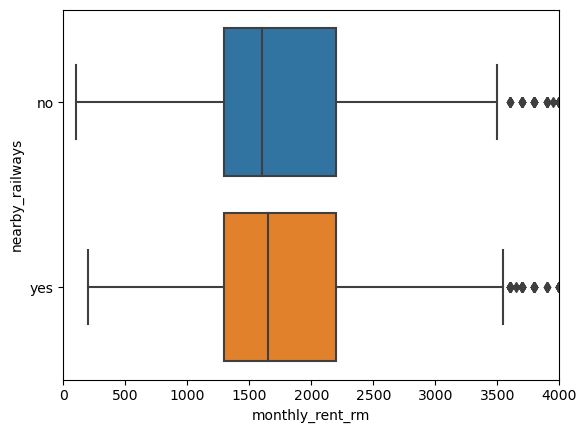

In [18]:
#| label: fig-nearbyktm
#| fig-cap: Boxplot between Nearby KTM/LRT or Not

sns.boxplot(data=df.to_pandas(), x='monthly_rent_rm', y='nearby_railways')
plt.xlim(0,4000)

In [19]:
df

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,nearby_railways
i64,str,f64,i64,str,str,str,f64,f64,i64,str,str,str,str,str
100284164,"""Residensi Jali…",null,850,"""Bukit Jalil""","""Apartment""","""3""",null,2.0,800,"""Not Furnished""","""Minimart, Mult…",null,"""Kuala Lumpur""",null
99887563,"""Majestic Maxim…",2021.0,1400,"""Cheras""","""Service Reside…","""3""",1.0,2.0,819,"""Partially Furn…","""Parking, Gymna…",null,"""Kuala Lumpur""",null
99769112,"""Casa Magna""",null,1100,"""Kepong""","""Apartment""","""3""",1.0,2.0,1010,"""Not Furnished""","""Security, Barb…","""Cooking Allowe…","""Kuala Lumpur""","""no"""
99563109,"""Mentari Condom…",null,1800,"""Cheras""","""Condominium""","""3""",2.0,2.0,1025,"""Fully Furnishe…","""Security, Gymn…",null,"""Kuala Lumpur""",null
100126144,"""Residensi Raza…",null,900,"""Cheras""","""Apartment""","""3""",null,2.0,850,"""Partially Furn…",null,null,"""Kuala Lumpur""",null
98244338,null,null,2500,"""Sentul""","""Condominium""","""3""",2.0,3.0,1300,"""Fully Furnishe…","""Parking, Secur…",null,"""Kuala Lumpur""",null
99859506,"""Taman Castlefi…",null,750,"""Sungai Besi""","""Apartment""","""2""",null,1.0,700,"""Partially Furn…","""Parking, Secur…","""Near KTM/LRT, …","""Kuala Lumpur""","""yes"""
99830019,"""M Vertica""",2023.0,2500,"""Cheras""","""Condominium""","""3""",2.0,2.0,850,"""Fully Furnishe…","""Swimming Pool,…",null,"""Kuala Lumpur""",null
99748004,"""Setapak Ria Co…",1994.0,1250,"""Setapak""","""Condominium""","""3""",1.0,2.0,1178,"""Not Furnished""","""Playground, Pa…",null,"""Kuala Lumpur""",null


In [20]:
df.filter(pl.col('prop_name') == 'Majestic Maxim')["nearby_railways"].value_counts()

nearby_railways,counts
str,u32
"""yes""",166
"""no""",24
null,32


####
As seen above, @fig-nearbyktm shows that it sligthly increases the median monthly rent by 50RM. However, near KTM/LRT is not appearing in all row even though the property is the same

Conclusion: Near KTM/LRT may be used, but it can be improved as the listing is inconsistent

##### Drop Missing Values in Facilities and Additional Facilities

In [21]:
df.select(pl.all().is_null()).sum()

ads_id,prop_name,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,facilities,additional_facilities,region,nearby_railways
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,508,4373,0,0,0,2,2630,2,0,1,895,2831,0,2831


In [22]:
# #dropping some columns
df = df.drop(['ads_id', 
    'prop_name', 
    'facilities', 
    'additional_facilities'])

In [23]:
df.select(pl.col("rooms")).unique()

rooms
str
"""9"""
"""4"""
"""1"""
"""7"""
"""More than 10"""
null
"""2"""
"""6"""
"""5"""


####
Converting rooms from object to int64

In [24]:
df = df.with_columns(pl.col("rooms").apply(lambda x: 10 if x == "More than 10" else x))

In [25]:
df = df.with_columns(pl.col("rooms").cast(pl.Float64))

In [26]:
df = df.with_columns(pl.col("rooms").cast(pl.Int64))

##### Outlier Removal
To remove some unexplainable data such as 0 monthly rent, 0 size, the rent that is way too old (1970), including the monthly rent that is way too high and/or size too big.

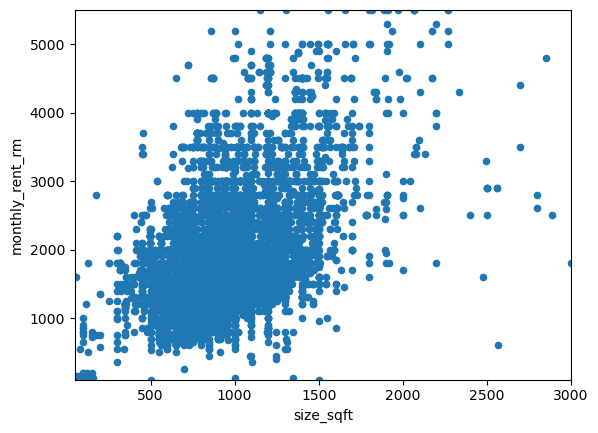

In [27]:
#| label: fig-size-rent
#| fig-cap: "Monthly Rent"
df.to_pandas()[['size_sqft', 'monthly_rent_rm']].plot(kind='scatter', x='size_sqft', y='monthly_rent_rm');
plt.ylim(100,5500)
plt.xlim(50,3000)
plt.show()

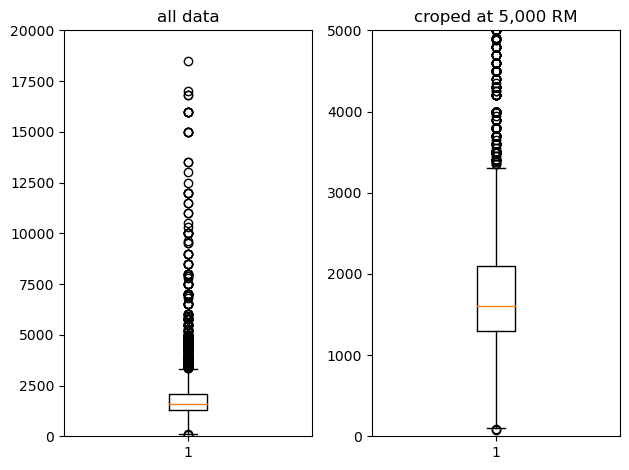

In [28]:
#| label: fig-compare-rent
#| fig-cap: "Comparison between Different Scale"
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data=df.to_pandas(), x='monthly_rent_rm')
axs[0].set_ylim(0,20000)
axs[0].set_title('all data')

axs[1].boxplot(data=df.to_pandas(), x='monthly_rent_rm')
axs[1].set_ylim(0,5000)
axs[1].set_title('croped at 5,000 RM')

plt.tight_layout()
plt.show()

#### 
Based on EDA on @fig-size-rent and @fig-compare-rent, author decided to filter the data between 100-5500 RM as follows:

In [29]:
df.columns

['completion_year',
 'monthly_rent_rm',
 'location',
 'property_type',
 'rooms',
 'parking',
 'bathroom',
 'size_sqft',
 'furnished',
 'region',
 'nearby_railways']

In [30]:
# removing all rows with monthly rent above 5500 RM and below 100RM
dfx = df.filter((pl.col("monthly_rent_rm") > 100) & (pl.col("monthly_rent_rm") < 5500))

In [31]:
dfx.describe()

describe,completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,nearby_railways
str,f64,f64,str,str,f64,f64,f64,f64,str,str,str
"""count""",9841.0,9841.0,"""9841""","""9841""",9841.0,9841.0,9841.0,9841.0,"""9841""","""9841""","""9841"""
"""null_count""",4311.0,0.0,"""0""","""0""",3.0,2596.0,1.0,0.0,"""0""","""0""","""2778"""
"""mean""",2014.86311,1786.84026,null,null,2.742427,1.339268,1.92876,11112.787522,null,null,null
"""std""",7.436904,768.813626,null,null,0.7637,0.517512,0.517118,1.0080e6,null,null,null
"""min""",1980.0,110.0,"""Ampang""","""Apartment""",1.0,1.0,1.0,1.0,"""Fully Furnishe…","""Kuala Lumpur""","""no"""
"""max""",2025.0,5300.0,"""Wangsa Maju""","""Townhouse Cond…",9.0,10.0,6.0,9.9999999e7,"""Partially Furn…","""Kuala Lumpur""","""yes"""
"""median""",2017.0,1600.0,null,null,3.0,1.0,2.0,908.0,null,null,null


<Axes: >

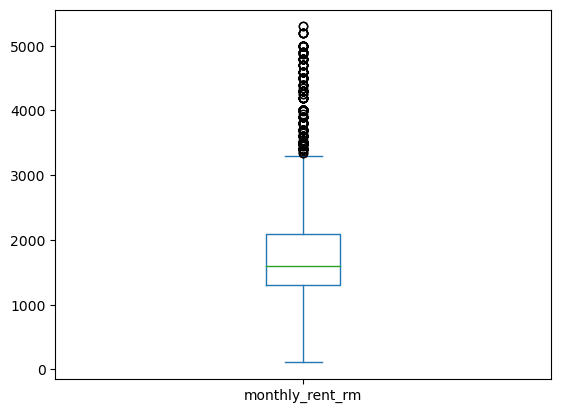

In [32]:
#| label: fig-rent-final
#| fig-cap: "Data after Outlier Removal"
dfx.to_pandas().monthly_rent_rm.plot(kind='box', x='monthly_rent_rm')

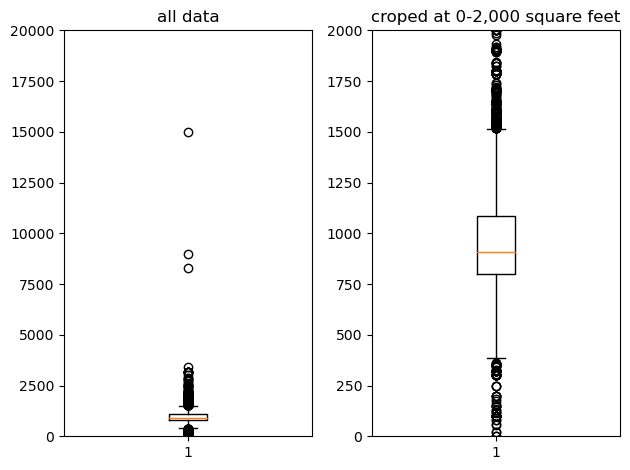

In [33]:
#| label: fig-size-comparison
#| fig-cap: "Raw Data Size sq.ft"
fig, axs = plt.subplots(1,2)
axs[0].boxplot(data=dfx.to_pandas(), x='size_sqft')
axs[0].set_ylim(0,20000)
axs[0].set_title('all data')

axs[1].boxplot(data=dfx.to_pandas(), x='size_sqft')
axs[1].set_ylim(0,2000)
axs[1].set_title('croped at 0-2,000 square feet')

plt.tight_layout()
plt.show()

In [34]:
#removing outliers below 500, and higher than 3000 sqft and below 50 sqft
dfx = dfx.filter((pl.col("size_sqft") > 50) & (pl.col("size_sqft") < 3000))

<Axes: >

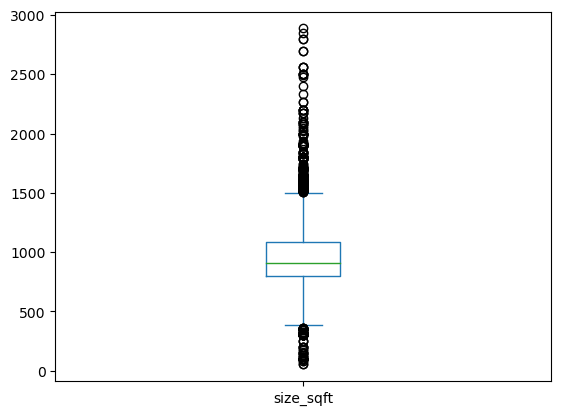

In [35]:
dfx.to_pandas()["size_sqft"].plot(kind='box')

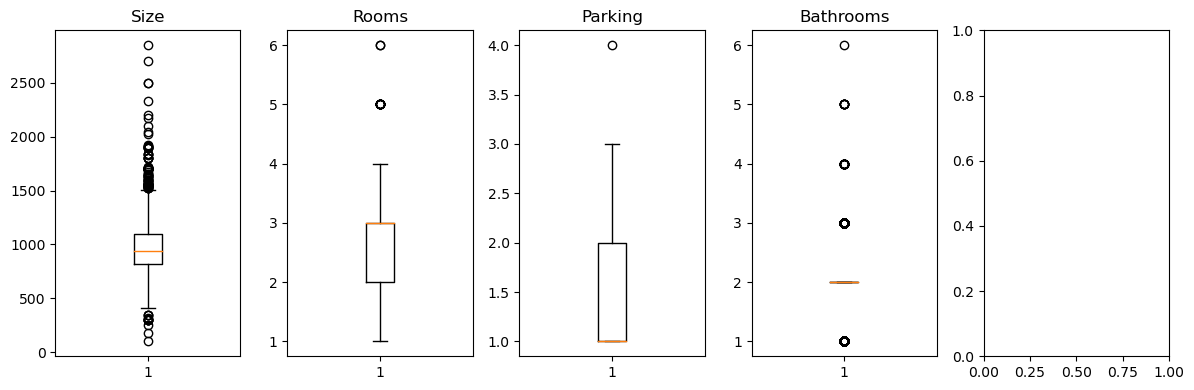

In [36]:
#| label: fig-complete-outliers
#| fig-cap: "Final Data after Outlier Removal"
fig, axs = plt.subplots(1,5, figsize=(12,4))
axs[0].boxplot(data=dfx.to_pandas().dropna(), x='size_sqft')
axs[1].boxplot(data=dfx.to_pandas().dropna(), x='rooms')
axs[2].boxplot(data=dfx.to_pandas().dropna(), x='parking')
axs[3].boxplot(data=dfx.to_pandas().dropna(), x='bathroom')
# axs[4].boxplot(data=dfx.dropna(), x='completion_year')

axs[0].set_title('Size')
axs[1].set_title('Rooms')
axs[2].set_title('Parking')
axs[3].set_title('Bathrooms')
# axs[4].set_title('Completion Year')

plt.tight_layout()
plt.show()

#### Data Preprocessing
##### Input-Output

##### Train-Test Split Data

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(dfx.drop("monthly_rent_rm").to_pandas(),
                                                    dfx.select(pl.col("monthly_rent_rm")).to_numpy(),
                                                    test_size = 0.2,
                                                    random_state = 123)

In [39]:
len(X_test)/len(dfx.drop("monthly_rent_rm").to_pandas())

0.20006108735491754

In [40]:
X_train

,completion_year,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,nearby_railways
5864,2020.0,Kepong,Service Residence,4.0,2.0,2.0,932,Fully Furnished,Kuala Lumpur,no
2120,2013.0,Cheras,Service Residence,2.0,1.0,2.0,719,Fully Furnished,Kuala Lumpur,yes
9546,NaN,Cheras,Condominium,1.0,1.0,1.0,900,Fully Furnished,Kuala Lumpur,yes
8409,1996.0,Cheras,Condominium,3.0,NaN,2.0,1100,Partially Furnished,Kuala Lumpur,None
2764,2012.0,Bukit Bintang,Service Residence,1.0,1.0,1.0,475,Fully Furnished,Kuala Lumpur,yes
...,...,...,...,...,...,...,...,...,...,...
9785,2021.0,Sentul,Service Residence,2.0,1.0,1.0,800,Partially Furnished,Kuala Lumpur,yes
7763,2022.0,Mont Kiara,Service Residence,1.0,NaN,1.0,600,Fully Furnished,Kuala Lumpur,no
5218,2019.0,Setapak,Condominium,4.0,3.0,3.0,1450,Fully Furnished,Kuala Lumpur,yes
1346,NaN,Wangsa Maju,Apartment,2.0,1.0,1.0,600,Partially Furnished,Kuala Lumpur,yes


##### Preprocessing Original Data for Categorical Dtypes

One must paying attention to the number of categorical observation in the original data, with respect to the sampling train-test value. If, the test_size = 0.3, that means any categorical observation with a total of 3 and less, would not be distributed evenly among train and test data.

In [41]:
print(dfx["location"].n_unique())
print(X_train.location.nunique())
print(X_test.location.nunique())

60
60
54


In [42]:
print(dfx["property_type"].n_unique())
print(X_train.property_type.nunique())
print(X_test.property_type.nunique())

9
9
8


In [43]:
print(set(X_train.furnished.to_list()) - set(X_test.furnished.to_list()))
print(set(X_train.location.to_list()) - set(X_test.location.to_list()))
print(set(X_train.property_type.to_list()) - set(X_test.property_type.to_list()))
print(set(X_train.nearby_railways.to_list()) - set(X_test.nearby_railways.to_list()))

set()
{'Sungai Penchala', 'Salak Selatan', 'Others', 'Bandar Damai Perdana', 'Chan Sow Lin', 'Mid Valley City'}
{'Condo / Services residence / Penthouse / Townhouse'}
set()


#### 
Dropping Data

In [44]:
exclude_location = dfx["location"].value_counts().sort("counts").head(11)["location"].to_numpy()

In [45]:
dfx["property_type"].value_counts().sort("property_type")

property_type,counts
str,u32
"""Apartment""",2123
"""Condo / Servic…",1
"""Condominium""",4698
"""Duplex""",27
"""Flat""",265
"""Others""",27
"""Service Reside…",2647
"""Studio""",27
"""Townhouse Cond…",7


In [46]:
dfx_new = dfx.filter((~pl.col("location").is_in(exclude_location.tolist())))
dfx_new = dfx_new.filter((~pl.col("property_type").is_in(["Condo / Services residence / Penthouse / Townhouse", "Townhouse Condo"])))

In [47]:
dfx_new["property_type"].value_counts()

property_type,counts
str,u32
"""Studio""",26
"""Apartment""",2112
"""Service Reside…",2633
"""Duplex""",27
"""Condominium""",4680
"""Others""",26
"""Flat""",259


In [48]:
dfx_new

completion_year,monthly_rent_rm,location,property_type,rooms,parking,bathroom,size_sqft,furnished,region,nearby_railways
f64,i64,str,str,i64,f64,f64,i64,str,str,str
null,850,"""Bukit Jalil""","""Apartment""",3,null,2.0,800,"""Not Furnished""","""Kuala Lumpur""",null
2021.0,1400,"""Cheras""","""Service Reside…",3,1.0,2.0,819,"""Partially Furn…","""Kuala Lumpur""",null
null,1100,"""Kepong""","""Apartment""",3,1.0,2.0,1010,"""Not Furnished""","""Kuala Lumpur""","""no"""
null,1800,"""Cheras""","""Condominium""",3,2.0,2.0,1025,"""Fully Furnishe…","""Kuala Lumpur""",null
null,900,"""Cheras""","""Apartment""",3,null,2.0,850,"""Partially Furn…","""Kuala Lumpur""",null
null,2500,"""Sentul""","""Condominium""",3,2.0,3.0,1300,"""Fully Furnishe…","""Kuala Lumpur""",null
null,750,"""Sungai Besi""","""Apartment""",2,null,1.0,700,"""Partially Furn…","""Kuala Lumpur""","""yes"""
2023.0,2500,"""Cheras""","""Condominium""",3,2.0,2.0,850,"""Fully Furnishe…","""Kuala Lumpur""",null
1994.0,1250,"""Setapak""","""Condominium""",3,1.0,2.0,1178,"""Not Furnished""","""Kuala Lumpur""",null


In [49]:
X_train, X_test, y_train, y_test = train_test_split(dfx_new.drop("monthly_rent_rm").to_pandas(),
                                                    dfx_new.select(pl.col("monthly_rent_rm")).to_numpy(),
                                                    test_size = 0.2,
                                                    random_state = 123)

In [50]:
print(set(X_train.furnished.to_list()) - set(X_test.furnished.to_list()))
print(set(X_train.location.to_list()) - set(X_test.location.to_list()))
print(set(X_train.property_type.to_list()) - set(X_test.property_type.to_list()))

set()
set()
set()


In [51]:
print(dfx_new["location"].n_unique())
print(X_train.location.nunique())
print(X_test.location.nunique())

49
49
49


##### Training Data Imputation

In [52]:
X_train.isna().sum()

completion_year    3398
location              0
property_type         0
rooms                 2
parking            2036
bathroom              0
size_sqft             0
furnished             0
region                0
nearby_railways    2214
dtype: int64

In [53]:
X_train_num = X_train.select_dtypes(exclude='object')

In [54]:
X_train_num.isna().sum()

completion_year    3398
rooms                 2
parking            2036
bathroom              0
size_sqft             0
dtype: int64

##### 
We can fill completion year, rooms, parking and bathroom with mode

In [55]:
from sklearn.impute import SimpleImputer
def numericalImputation(X_train_num, strategy = 'most_frequent'):
    # create imputer
    imputer_num = SimpleImputer(missing_values = np.nan, strategy = strategy)
    
    # fitting
    imputer_num.fit(X_train_num)

    # transform
    imputed_data = imputer_num.transform(X_train_num)
    X_train_num_imputed = pd.DataFrame(imputed_data)

    # making imputated and non-imputated columns are the same
    X_train_num_imputed.columns = X_train_num.columns
    X_train_num_imputed.index = X_train_num.index

    return X_train_num_imputed, imputer_num

In [56]:
def numericalImputationNone(X_train_num, strategy = 'most_frequent'):
    # create imputer
    imputer_num = SimpleImputer(missing_values = None, strategy = strategy)
    
    # fitting
    imputer_num.fit(X_train_num)

    # transform
    imputed_data = imputer_num.transform(X_train_num)
    X_train_num_imputed = pd.DataFrame(imputed_data)

    # making imputated and non-imputated columns are the same
    X_train_num_imputed.columns = X_train_num.columns
    X_train_num_imputed.index = X_train_num.index

    return X_train_num_imputed, imputer_num

In [57]:
X_train_num, imputer_num = numericalImputation(X_train_num, strategy='most_frequent')
X_train_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Categorical Data

In [58]:
X_train_cat = X_train.select_dtypes(include='object')

In [59]:
X_train_cat

,location,property_type,furnished,region,nearby_railways
7863,Cheras,Condominium,Partially Furnished,Kuala Lumpur,None
7319,Ampang,Condominium,Fully Furnished,Kuala Lumpur,yes
1878,Taman Melawati,Apartment,Not Furnished,Kuala Lumpur,yes
5454,Mont Kiara,Condominium,Fully Furnished,Kuala Lumpur,no
7941,Kepong,Service Residence,Partially Furnished,Kuala Lumpur,yes
...,...,...,...,...,...
7382,Cheras,Service Residence,Partially Furnished,Kuala Lumpur,None
7763,Titiwangsa,Service Residence,Fully Furnished,Kuala Lumpur,yes
5218,Cheras,Service Residence,Partially Furnished,Kuala Lumpur,yes
1346,Cheras,Condominium,Fully Furnished,Kuala Lumpur,no


In [60]:
X_train_cat.isna().sum()

location              0
property_type         0
furnished             0
region                0
nearby_railways    2214
dtype: int64

#### 
Impute with mode

In [61]:
X_train_cat, imputer_num = numericalImputationNone(X_train_cat, strategy='most_frequent')
X_train_cat.isna().sum()

location           0
property_type      0
furnished          0
region             0
nearby_railways    0
dtype: int64

In [62]:
imputer_num

SimpleImputer(missing_values=None, strategy='most_frequent')

##### Preprocessing Categorical Variable

In [63]:
X_train_cat_ohe =  pd.get_dummies(X_train_cat)

In [64]:
X_train_cat_ohe

,location_Ampang,location_Ampang Hilir,location_Bandar Menjalara,location_Bandar Tasik Selatan,location_Bangsar,location_Bangsar South,location_Brickfields,location_Bukit Bintang,location_Bukit Jalil,location_Cheras,...,property_type_Flat,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,nearby_railways_no,nearby_railways_yes
7863,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,True,True,False,True
7319,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
1878,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
5454,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,True,False
7941,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,True,True,False,True
7763,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
5218,False,False,False,False,False,False,False,False,False,True,...,False,False,True,False,False,False,True,True,False,True
1346,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,True,False,False,True,True,False


In [65]:
ohe_columns = X_train_cat_ohe.columns

In [66]:
X_train_cat_ohe.isna().sum()

location_Ampang                  0
location_Ampang Hilir            0
location_Bandar Menjalara        0
location_Bandar Tasik Selatan    0
location_Bangsar                 0
                                ..
furnished_Not Furnished          0
furnished_Partially Furnished    0
region_Kuala Lumpur              0
nearby_railways_no               0
nearby_railways_yes              0
Length: 62, dtype: int64

In [67]:
X_train_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Combine Numerical dan Categorical data

In [72]:
X_train_concat = pd.concat([X_train_num, X_train_cat_ohe], axis = 1)

In [73]:
X_train_concat

,completion_year,rooms,parking,bathroom,size_sqft,location_Ampang,location_Ampang Hilir,location_Bandar Menjalara,location_Bandar Tasik Selatan,location_Bangsar,...,property_type_Flat,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,nearby_railways_no,nearby_railways_yes
7863,2015.0,4.0,1.0,2.0,1142.0,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
7319,2012.0,4.0,1.0,2.0,1300.0,True,False,False,False,False,...,False,False,False,False,True,False,False,True,False,True
1878,2021.0,2.0,1.0,2.0,875.0,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,True
5454,2021.0,4.0,2.0,3.0,1250.0,False,False,False,False,False,...,False,False,False,False,True,False,False,True,True,False
7941,2020.0,3.0,2.0,2.0,932.0,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,2021.0,2.0,1.0,2.0,650.0,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
7763,2013.0,2.0,1.0,1.0,737.0,False,False,False,False,False,...,False,False,True,False,True,False,False,True,False,True
5218,2021.0,2.0,1.0,2.0,670.0,False,False,False,False,False,...,False,False,True,False,False,False,True,True,False,True
1346,2021.0,4.0,2.0,3.0,1200.0,False,False,False,False,False,...,False,False,False,False,True,False,False,True,True,False


In [74]:
X_train_concat.isnull().sum()

completion_year                  0
rooms                            0
parking                          0
bathroom                         0
size_sqft                        0
                                ..
furnished_Not Furnished          0
furnished_Partially Furnished    0
region_Kuala Lumpur              0
nearby_railways_no               0
nearby_railways_yes              0
Length: 67, dtype: int64

#### Standardization

In [75]:
from sklearn.preprocessing import StandardScaler
def standardizerData(data):
    data_columns = data.columns  #preserve columns
    data_index = data.index  #preserve index

    # create and fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [76]:
X_train_clean, standardizer = standardizerData(data = X_train_concat)

In [77]:
X_train_clean

,completion_year,rooms,parking,bathroom,size_sqft,location_Ampang,location_Ampang Hilir,location_Bandar Menjalara,location_Bandar Tasik Selatan,location_Bangsar,...,property_type_Flat,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,nearby_railways_no,nearby_railways_yes
7863,-0.391594,1.663148,-0.533670,0.146120,0.748619,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,-0.607630,-0.051924,-0.942980,-0.396279,1.241235,0.0,-0.621669,0.621669
7319,-0.858352,1.663148,-0.533670,0.146120,1.343552,5.367417,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,-0.607630,-0.051924,1.060468,-0.396279,-0.805649,0.0,-0.621669,0.621669
1878,0.541921,-0.981769,-0.533670,0.146120,-0.256744,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,-0.607630,-0.051924,-0.942980,2.523475,-0.805649,0.0,-0.621669,0.621669
5454,0.541921,1.663148,1.649652,2.144711,1.155282,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,-0.607630,-0.051924,1.060468,-0.396279,-0.805649,0.0,1.608573,-1.608573
7941,0.386335,0.340690,1.649652,0.146120,-0.042116,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,1.645738,-0.051924,-0.942980,-0.396279,1.241235,0.0,-0.621669,0.621669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7382,0.541921,-0.981769,-0.533670,0.146120,-1.103960,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,1.645738,-0.051924,-0.942980,-0.396279,1.241235,0.0,-0.621669,0.621669
7763,-0.702766,-0.981769,-0.533670,-1.852472,-0.776370,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,1.645738,-0.051924,1.060468,-0.396279,-0.805649,0.0,-0.621669,0.621669
5218,0.541921,-0.981769,-0.533670,0.146120,-1.028652,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,1.645738,-0.051924,-0.942980,-0.396279,1.241235,0.0,-0.621669,0.621669
1346,0.541921,1.663148,1.649652,2.144711,0.967012,-0.186309,-0.089454,-0.059984,-0.032022,-0.068993,...,-0.160023,-0.050669,-0.607630,-0.051924,1.060468,-0.396279,-0.805649,0.0,1.608573,-1.608573


##### Training Machine Learning
Since this is a regression model, R2 score and mean absolute error (MAE) will be used as a performance metrics.

The machine learning model will use baseline from average value of the target columns (monthly rent) and also result from linear regression model. After that, author used some of the recommended model based on previous works, which are random forest and gradient boosting to better improve the performance of the model.

##### Baseline-Average Value
The concept here is to use average value of the target as the easiest way to predict the monhtly rent of a unit.

In [78]:
y_baseline = np.ones(len(y_train)) * y_train.mean()
y_baseline

array([1795.23777209, 1795.23777209, 1795.23777209, ..., 1795.23777209,
       1795.23777209, 1795.23777209])

In [79]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Train the linear regression model
lin_reg = LinearRegression().fit(X_train_clean, y_train)

# Predict using the train data
y_pred_train = y_baseline

# Calculate R-squared
r2_baseline = r2_score(y_train, y_pred_train)

# Calculate MAE
mae_baseline = mean_absolute_error(y_train, y_pred_train)

print(f"R2-score: {r2_baseline:.4f} and MAE score: {mae_baseline:.4f}")

R2-score: 0.0000 and MAE score: 564.8385


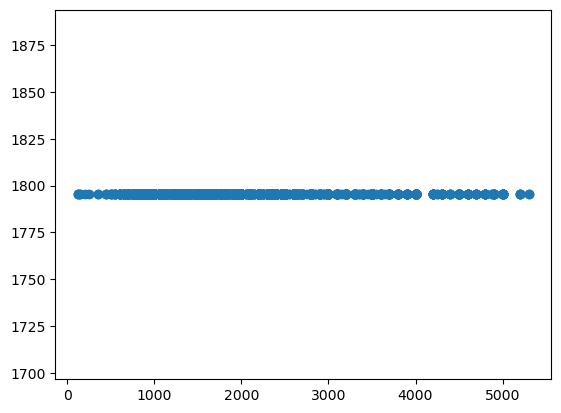

In [80]:
plt.scatter(x=y_train, y=y_pred_train);

##### Baseline-Linear Regression
The second method is using linear regression, which simply put is finding the minum total error (distance) between predicted value and the target value, using linear equation.

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the linear regression model
lin_reg = LinearRegression().fit(X_train_clean, y_train)

# Predict using the train data
# y_pred = y_baseline
y_pred_train = lin_reg.predict(X_train_clean)

# Calculate mean absolute error
mae_linreg = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_linreg = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_linreg:.4f} and MAE score: {mae_linreg:.4f}")

R2-score: 0.6523 and MAE score: 318.9801


In [82]:
y_train.flatten()

array([1490, 2100, 1500, ..., 1400, 2500, 1400])

In [83]:
y_pred_train.shape

(7810, 1)

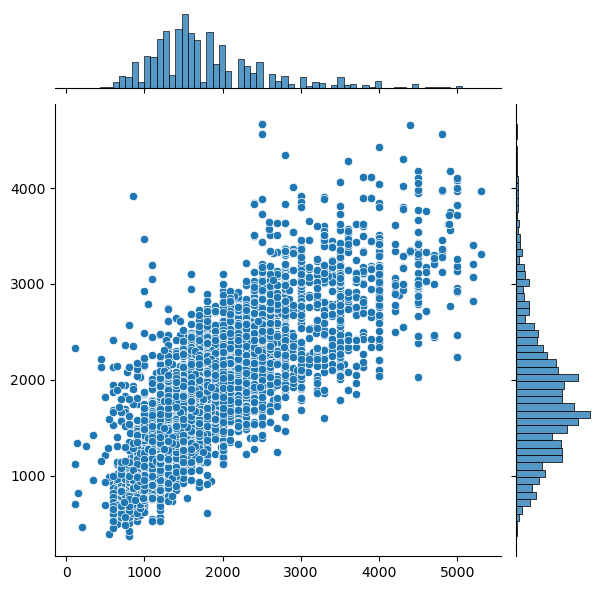

In [84]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

##### GradientBoosting
The gradient boosting, is one of the recommendation from previous works, is a model where each sample would be given a different weights (boosts) depending on its performance in predicting the value/ target.

In [85]:
from sklearn.ensemble import GradientBoostingRegressor
# Build random forest
grad_tree = GradientBoostingRegressor(random_state = 123)

In [86]:
# Fit random forest
grad_tree.fit(X_train_clean, y_train.flatten())

GradientBoostingRegressor(random_state=123)

In [87]:
# Predict
y_pred_train = grad_tree.predict(X_train_clean)
# y_pred_test = grad_tree.predict(X_test_clean)

# Calculate mean absolute error
mae_gb = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_gb = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_gb:.4f} and MAE score: {mae_gb:.4f}")

R2-score: 0.7285 and MAE score: 280.4728


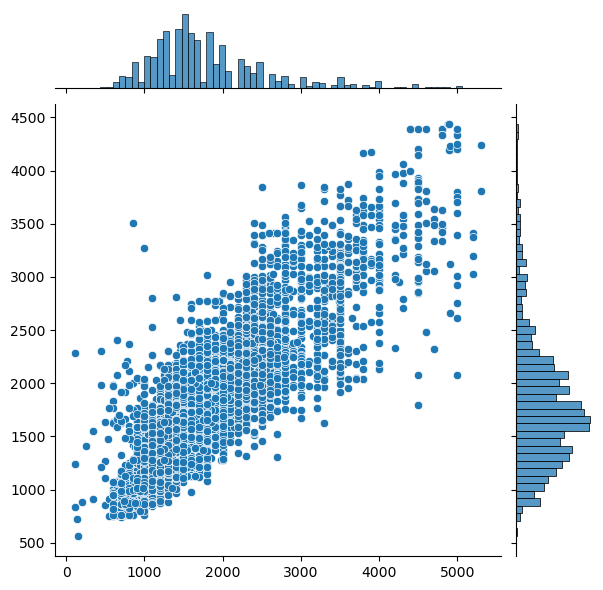

In [88]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten());

In [89]:
# GridSearch

from sklearn.model_selection import GridSearchCV 


params = {'n_estimators': [100, 200, 300, 400, 500],
              'learning_rate': [0.1, 0.05, 0.01]}

# Create gridsearch
grad_tree = GradientBoostingRegressor(random_state = 123)

grad_tree_cv = GridSearchCV(estimator = grad_tree,
                           param_grid = params,
                           cv = 5,
                           scoring = "neg_mean_absolute_error")

In [90]:
# Fit GridSearchCV
grad_tree_cv.fit(X_train_clean, y_train.flatten())

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=123),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'n_estimators': [100, 200, 300, 400, 500]},
             scoring='neg_mean_absolute_error')

In [91]:
grad_tree_cv.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [92]:
# Refit the Adaboost
grad_tree = GradientBoostingRegressor(n_estimators = grad_tree_cv.best_params_["n_estimators"],
                                      random_state = 123)

grad_tree.fit(X_train_clean, y_train.flatten())

GradientBoostingRegressor(n_estimators=500, random_state=123)

In [93]:
# Predict
y_pred_train = grad_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_gb_cv = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_gb_cv = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_gb_cv:.4f} and MAE score: {mae_gb_cv:.4f}")

R2-score: 0.8221 and MAE score: 227.0214


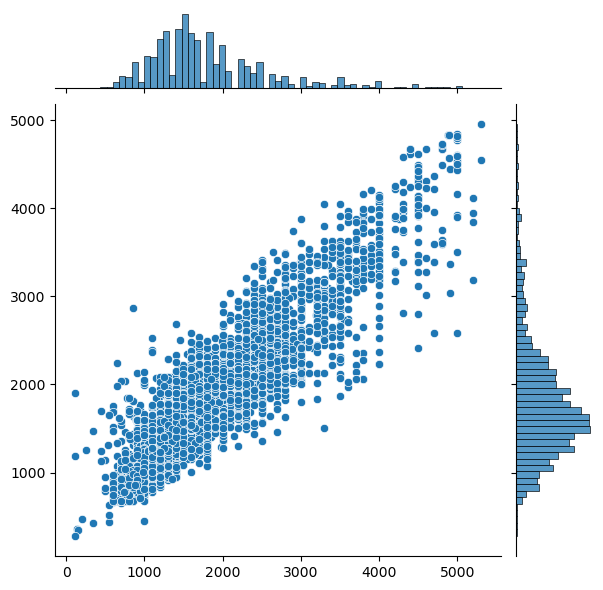

In [94]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

##### Random Forest
The last model, which was also recommended by previous works, is a model where not only it has weights based on its performance, but the feature selection in which the sample is measured was done at random. Therefore, reduces not only the variance, but also the bias.

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [96]:
# Build random forest
rf_tree = RandomForestRegressor(n_estimators = 100,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

In [97]:
# Fit random forest
rf_tree.fit(X_train_clean, y_train.flatten())

RandomForestRegressor(max_features='sqrt', random_state=123)

In [98]:
# Predict
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_rf = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf:.4f} and MAE score: {mae_rf:.4f}")

R2-score: 0.9581 and MAE score: 99.9166


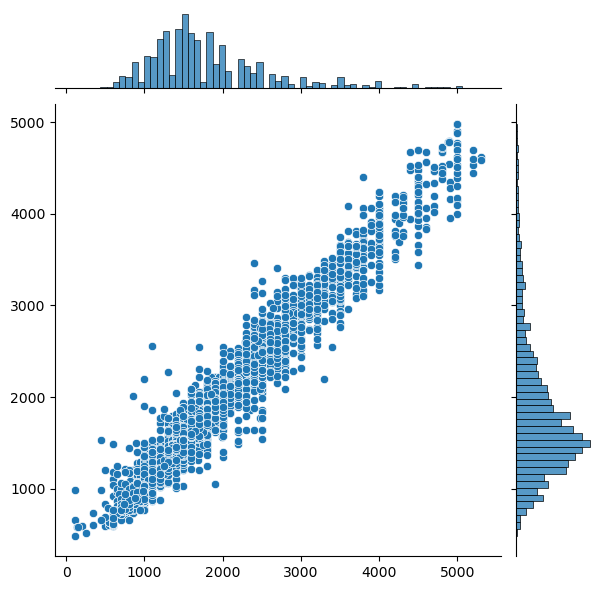

In [99]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

In [100]:
params = {"n_estimators": [100, 200, 300, 500 ],
          "max_features": ["sqrt", "log2"]}

# Create GridSearch
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                random_state = 123)

rf_tree_cv = GridSearchCV(estimator = rf_tree,
                          param_grid = params,
                          cv = 5,
                          scoring = "neg_mean_absolute_error")

In [101]:
# Fit grid search cv
rf_tree_cv.fit(X_train_clean, y_train.flatten())

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=123),
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='neg_mean_absolute_error')

In [102]:
# Best params
rf_tree_cv.best_params_

{'max_features': 'sqrt', 'n_estimators': 500}

In [103]:
# Refit the Random Forest
rf_tree = RandomForestRegressor(criterion = "squared_error",
                                max_features = rf_tree_cv.best_params_["max_features"],
                                n_estimators = rf_tree_cv.best_params_["n_estimators"],
                                random_state = 123)

rf_tree.fit(X_train_clean, y_train.flatten())

RandomForestRegressor(max_features='sqrt', n_estimators=500, random_state=123)

In [104]:
# Predict
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf_cv = mean_absolute_error(y_train, y_pred_train)

# # Calculate R-squared
r2_rf_cv = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf_cv:.4f} and MAE score: {mae_rf_cv:.4f}")

R2-score: 0.9595 and MAE score: 98.7463


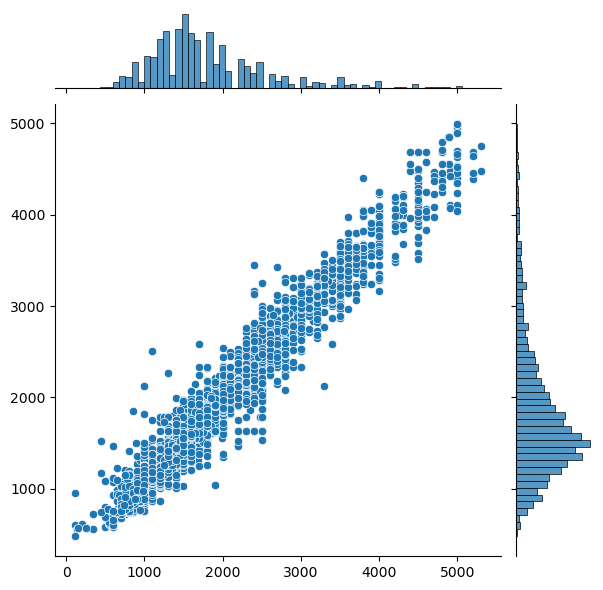

In [105]:
sns.jointplot(x=y_train.flatten(), y=y_pred_train.flatten())

In [106]:
mae_score = [mae_baseline, mae_linreg, mae_gb, mae_gb_cv, mae_rf, mae_rf_cv]
r2_score = [r2_baseline, r2_linreg, r2_gb, r2_gb_cv, r2_rf, r2_rf_cv]
indexes = ["baseline", "linear regression", "gradient boosting", "gradient boosting with CV", "random forest",  "random forest with CV"]

summary_df = pd.DataFrame({
    "MAE Train": mae_score,
    "R2-Score": r2_score,
},index = indexes)

summary_df.sort_values(by='R2-Score', ascending=False)

,MAE Train,R2-Score
random forest with CV,98.746326,0.959495
random forest,99.916567,0.958068
gradient boosting with CV,227.021413,0.822104
gradient boosting,280.472799,0.728498
linear regression,318.980146,0.652318
baseline,564.838531,0.000000


#### 
From the above table, it can be seen that Random Forest model performs the best, and Gradient Boosting at the second place. This is similar to the previous work done by others, on house pricing.

##### Best Model

R2-score: 0.959 and MAE score: +/-98.75 RM


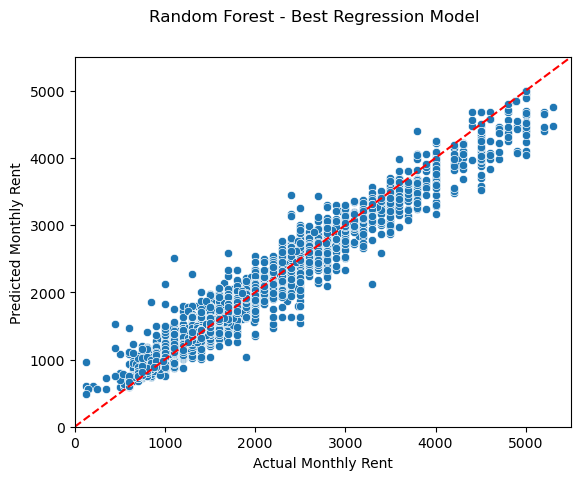

In [107]:
# Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Setting up
rf_tree = RandomForestRegressor(n_estimators = 500,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

# Fit model train
rf_tree.fit(X_train_clean, y_train.flatten())

# Predict model train
y_pred_train = rf_tree.predict(X_train_clean)

# Calculate mean absolute error
mae_rf_cv_train = mean_absolute_error(y_train, y_pred_train)

# Calculate R-squared
r2_rf_cv_train = r2_score(y_train, y_pred_train)

print(f"R2-score: {r2_rf_cv_train:.3f} and MAE score: +/-{mae_rf_cv_train:.2f} RM")

sns.scatterplot(x=y_train.flatten(), y=y_pred_train.flatten() )
plt.plot([0, 5500], [0,5500], "--r")
plt.xlim(0, 5500)
plt.xlabel("Actual Monthly Rent")
plt.ylim(0,5500)
plt.ylabel("Predicted Monthly Rent")
plt.suptitle("Random Forest - Best Regression Model")
plt.show()

### Data Prediction

##### Test Data Preprocessing
Simlar process done in train dataset need to be repeated on test dataset.

In [108]:
# Checking null data
X_test.isna().sum()

completion_year    865
location             0
property_type        0
rooms                0
parking            540
bathroom             0
size_sqft            0
furnished            0
region               0
nearby_railways    542
dtype: int64

In [109]:
X_test_num =  X_test.select_dtypes(exclude='object')
X_test_num

,completion_year,rooms,parking,bathroom,size_sqft
7961,NaN,3.0,1.0,2.0,765
8435,2020.0,3.0,NaN,2.0,850
1638,NaN,3.0,NaN,2.0,850
7298,NaN,3.0,1.0,2.0,1000
494,NaN,3.0,1.0,2.0,821
...,...,...,...,...,...
7989,NaN,3.0,1.0,2.0,922
5163,2021.0,3.0,1.0,2.0,820
4680,NaN,3.0,NaN,2.0,900
8779,NaN,3.0,1.0,2.0,1060


In [110]:
X_test_num.isna().sum()

completion_year    865
rooms                0
parking            540
bathroom             0
size_sqft            0
dtype: int64

In [111]:
X_test_num, imputer_num = numericalImputation(X_test_num, strategy='most_frequent')
X_test_num.isna().sum()

completion_year    0
rooms              0
parking            0
bathroom           0
size_sqft          0
dtype: int64

##### Categorical Data

In [112]:
X_test_cat = X_test.select_dtypes(include='object')
X_test_cat

,location,property_type,furnished,region,nearby_railways
7961,Desa Petaling,Condominium,Partially Furnished,Kuala Lumpur,no
8435,Pantai,Apartment,Partially Furnished,Kuala Lumpur,None
1638,Taman Desa,Condominium,Fully Furnished,Kuala Lumpur,None
7298,Bukit Jalil,Apartment,Fully Furnished,Kuala Lumpur,None
494,Kepong,Apartment,Fully Furnished,Kuala Lumpur,yes
...,...,...,...,...,...
7989,Bukit Bintang,Condominium,Not Furnished,Kuala Lumpur,no
5163,Cheras,Service Residence,Partially Furnished,Kuala Lumpur,yes
4680,Desa Petaling,Condominium,Not Furnished,Kuala Lumpur,None
8779,Pandan Jaya,Condominium,Not Furnished,Kuala Lumpur,yes


In [113]:
X_test_cat.isna().sum()

location             0
property_type        0
furnished            0
region               0
nearby_railways    542
dtype: int64

In [114]:
X_test_cat, imputer_num = numericalImputationNone(X_test_cat, strategy='most_frequent')
X_test_cat.isna().sum()

location           0
property_type      0
furnished          0
region             0
nearby_railways    0
dtype: int64

#### Categorical OHE

In [115]:
X_test_cat_ohe =  pd.get_dummies(X_test_cat)
X_test_cat_ohe.head(2)

,location_Ampang,location_Ampang Hilir,location_Bandar Menjalara,location_Bandar Tasik Selatan,location_Bangsar,location_Bangsar South,location_Brickfields,location_Bukit Bintang,location_Bukit Jalil,location_Cheras,...,property_type_Flat,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,nearby_railways_no,nearby_railways_yes
7961,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,False
8435,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


In [116]:
ohe_columns = X_test_cat_ohe.columns
ohe_columns

Index(['location_Ampang', 'location_Ampang Hilir', 'location_Bandar Menjalara',
       'location_Bandar Tasik Selatan', 'location_Bangsar',
       'location_Bangsar South', 'location_Brickfields',
       'location_Bukit Bintang', 'location_Bukit Jalil', 'location_Cheras',
       'location_City Centre', 'location_Damansara Heights',
       'location_Desa Pandan', 'location_Desa ParkCity',
       'location_Desa Petaling', 'location_Gombak', 'location_Jalan Ipoh',
       'location_Jalan Kuching', 'location_Jalan Sultan Ismail',
       'location_KL City', 'location_KLCC', 'location_Kepong',
       'location_Keramat', 'location_Kuchai Lama', 'location_Mid Valley City',
       'location_Mont Kiara', 'location_OUG', 'location_Old Klang Road',
       'location_Pandan Indah', 'location_Pandan Jaya',
       'location_Pandan Perdana', 'location_Pantai', 'location_Puchong',
       'location_Pudu', 'location_Segambut', 'location_Sentul',
       'location_Seputeh', 'location_Setapak', 'location_Seti

In [117]:
X_test_concat = pd.concat([X_test_num,
                            X_test_cat_ohe],
                           axis = 1)

In [118]:
X_test_concat.head(2)

,completion_year,rooms,parking,bathroom,size_sqft,location_Ampang,location_Ampang Hilir,location_Bandar Menjalara,location_Bandar Tasik Selatan,location_Bangsar,...,property_type_Flat,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,nearby_railways_no,nearby_railways_yes
7961,2021.0,3.0,1.0,2.0,765.0,False,False,False,False,False,...,False,False,False,False,False,False,True,True,True,False
8435,2020.0,3.0,1.0,2.0,850.0,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


In [119]:
#sanity check
X_test_concat.isnull().sum()

completion_year                  0
rooms                            0
parking                          0
bathroom                         0
size_sqft                        0
                                ..
furnished_Not Furnished          0
furnished_Partially Furnished    0
region_Kuala Lumpur              0
nearby_railways_no               0
nearby_railways_yes              0
Length: 67, dtype: int64

##### Standardization

In [120]:
from sklearn.preprocessing import StandardScaler
def standardizerData(data):
    data_columns = data.columns  # agar nama kolom tidak hilang
    data_index = data.index  # agar index tidak hilang

    # create and fit standardizer
    standardizer = StandardScaler()
    standardizer.fit(data)

    # transform data
    standardized_data_raw = standardizer.transform(data)
    standardized_data = pd.DataFrame(standardized_data_raw)
    standardized_data.columns = data_columns
    standardized_data.index = data_index

    return standardized_data, standardizer

In [121]:
X_test_clean, standardizer = standardizerData(data = X_test_concat)

In [122]:
X_test_clean.head()

,completion_year,rooms,parking,bathroom,size_sqft,location_Ampang,location_Ampang Hilir,location_Bandar Menjalara,location_Bandar Tasik Selatan,location_Bangsar,...,property_type_Flat,property_type_Others,property_type_Service Residence,property_type_Studio,furnished_Fully Furnished,furnished_Not Furnished,furnished_Partially Furnished,region_Kuala Lumpur,nearby_railways_no,nearby_railways_yes
7961,0.550171,0.337389,-0.572493,0.142609,-0.631657,-0.182574,-0.090886,-0.093707,-0.050663,-0.07174,...,-0.184066,-0.055513,-0.607919,-0.050663,-0.911244,-0.408248,1.215906,0.0,1.591115,-1.591115
8435,0.385575,0.337389,-0.572493,0.142609,-0.316855,-0.182574,-0.090886,-0.093707,-0.050663,-0.07174,...,-0.184066,-0.055513,-0.607919,-0.050663,-0.911244,-0.408248,1.215906,0.0,-0.628490,0.628490
1638,0.550171,0.337389,-0.572493,0.142609,-0.316855,-0.182574,-0.090886,-0.093707,-0.050663,-0.07174,...,-0.184066,-0.055513,-0.607919,-0.050663,1.097401,-0.408248,-0.822432,0.0,-0.628490,0.628490
7298,0.550171,0.337389,-0.572493,0.142609,0.238680,-0.182574,-0.090886,-0.093707,-0.050663,-0.07174,...,-0.184066,-0.055513,-0.607919,-0.050663,1.097401,-0.408248,-0.822432,0.0,-0.628490,0.628490
494,0.550171,0.337389,-0.572493,0.142609,-0.424258,-0.182574,-0.090886,-0.093707,-0.050663,-0.07174,...,-0.184066,-0.055513,-0.607919,-0.050663,1.097401,-0.408248,-0.822432,0.0,-0.628490,0.628490


##### Test Data Result

R2-score: 0.787 and MAE score: +/-224.18 RM


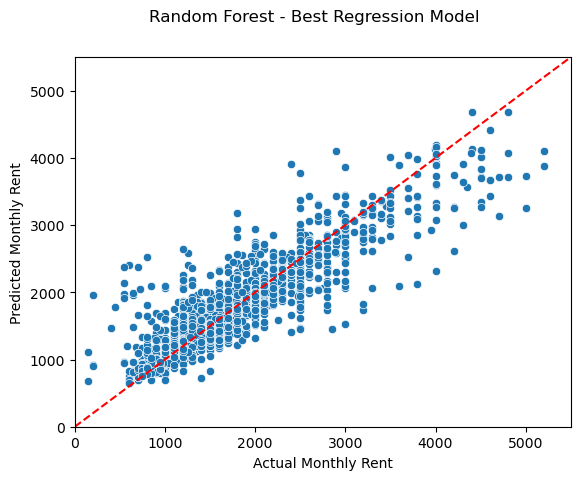

In [123]:
# libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


#setting up
rf_tree = RandomForestRegressor(n_estimators = 500,
                                criterion = "squared_error",
                                max_features = "sqrt",
                                random_state = 123)

#fit model train
rf_tree.fit(X_train_clean, y_train.flatten())

# Predict model
y_pred_test = rf_tree.predict(X_test_clean)

# Calculate mean absolute error
mae_rf_cv_test = mean_absolute_error(y_test, y_pred_test)

# # Calculate R-squared
r2_rf_cv_test = r2_score(y_test, y_pred_test)

print(f"R2-score: {r2_rf_cv_test:.3f} and MAE score: +/-{mae_rf_cv_test:.2f} RM")

sns.scatterplot(x=y_test.flatten(), y=y_pred_test.flatten())
plt.plot([0, 5500], [0,5500], "--r")
plt.xlim(0, 5500)
plt.xlabel("Actual Monthly Rent")
plt.ylim(0,5500)
plt.ylabel("Predicted Monthly Rent")
plt.suptitle("Random Forest - Best Regression Model")
plt.show()

In [124]:
mae_score = [mae_rf_cv_train, mae_rf_cv_test]
r2_score = [r2_rf_cv_train, r2_rf_cv_test]
indexes = ["train", "test"]

summary_df_train_test = pd.DataFrame({
    "MAE Train": mae_score,
    "R2-Score": r2_score,
},index = indexes)

summary_df_train_test

,MAE Train,R2-Score
train,98.746326,0.959495
test,224.179534,0.787325


##### Feature Importance

In [125]:
# calculate the feature importances
importances = rf_tree.feature_importances_

# rescale the importances back to the original scale of the features
importances = importances * X_train_clean.std()

# sort the feature importances in descending order
sorted_index = importances.argsort()[::-1]

# print the feature importances
dict_feature_importance = {}
for i in sorted_index:
    # print("{}: {}".format(X_train_clean.columns[i], importances[i]))
    dict_feature_importance.update({X_train_clean.columns[i]: importances[i]})
    
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict(dict_feature_importance, orient='index', columns=['values'])

# Reset the index to become a column
df = df.reset_index()

# Rename the columns
df.columns = ['feature', 'importance_value']

df.sort_values(by='importance_value', ascending=False).head(10)

,feature,importance_value
0,size_sqft,0.217996
1,furnished_Fully Furnished,0.119673
2,completion_year,0.071990
3,bathroom,0.058868
4,rooms,0.045541
5,parking,0.045294
6,location_Mont Kiara,0.042238
7,property_type_Apartment,0.039885
8,location_KLCC,0.038522
9,furnished_Partially Furnished,0.035208


##### Results
Result indicates that the best model for prediction is Random Forest with hyperparameter tuning, scoring 95% on R2-score, and a shy 100 RM on MAE. This proves to be a good model since the test dataset gives a scoring of 80% on R2, and 240 RM on MAE.

There are some factors that author believed to be affecting the result/ performance of the model:

Dropping missing value reduces the performance! Initial model uses half of the data (4-5k rows) and gives poorer performance on R2 and MAE. Imputation and keeping the number of rows close to the original dataset (9k rows) proves to be improving the model. Especially on test dataset.
Feature selection importance can be seen on the last table, but initially the selection was based on paper and intuition of the author (author lives and work in KL, Malaysia for 5 years). Feature such as completion_year and nearby_railways are important in improving the model.
Last but not least is the outlier identification. The best practice for me is using jointplot to see not only the distribution of the data in 2-dimension, but also in the third dimension (the density) of the data.
Some of the feature that were believed to be quite important even before doing the modeling is size, furnished and location. All three is available within the 10-most features affecting the modeling. As a context, location in KLCC is like Pondok Indah in South Jakarta. Location in Kiara is like BSD in South Tangerang.

#### Discussions
One of the feature that author thinks is significant but not appearing on the 10-best important feature is nearby_railways. This column is showing if a certain property has a close proximity to a railways (KTM/LRT). The issue is, half of the data is missing, hence the imputation. Author belives, the proximity to nearby railways line can be approximated using manhanttan distance of railways line to each property unit.